In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import umap
import os
import pickle
import pandas as pd
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [29]:
umap_dimensions = [2]
predefined_seeds = [42, 7, 19, 23, 1, 100, 56, 77, 89, 33, 8, 
                    13, 5, 21, 34, 99, 67, 18, 50, 81, 45, 22, 74, 37, 58, 
                    90, 16, 11, 29, 85]

In [30]:
base_path = "../embeddings/"
dataset_folders = {
        "Tuffery":"TUFFERY_REF", 
        "Proust": "STYLE_REF/PROUST_REF",
        "Celine": "STYLE_REF/CELINE_REF", 
        "Yourcenar":"STYLE_REF/YOURCENAR_REF",
        "Proust_mistral": "STYLE_GEN/PROUST_MISTRAL_GEN",
        "Celine_mistral": "STYLE_GEN/CELINE_MISTRAL_GEN", 
        "Yourcenar_mistral":"STYLE_GEN/YOURCENAR_MISTRAL_GEN",
        "Proust_gemini": "STYLE_GEN/PROUST_GEMINI_GEN",
        "Celine_gemini": "STYLE_GEN/CELINE_GEMINI_GEN", 
        "Yourcenar_gemini":"STYLE_GEN/YOURCENAR_GEMINI_GEN",
        "Proust_gpt": "STYLE_GEN/PROUST_GPT_GEN",
        "Celine_gpt": "STYLE_GEN/CELINE_GPT_GEN", 
        "Yourcenar_gpt":"STYLE_GEN/YOURCENAR_GPT_GEN",
    }
# dataset_folders = {
#         "Tuffery_ref":"TUFFERY_REF", 
#         "Style_ref": "STYLE_REF",
#         "Style_gen": "STYLE_GEN",
#     }

In [31]:
def load_embeddings_from_pickle(embeddings_dir):
    try:
        with open(embeddings_dir, 'rb') as f:
            embeddings = pickle.load(f)
        return embeddings
    except FileNotFoundError as e:
        print(f"File not found: {embeddings_dir}")
        raise e

In [32]:
model_name = "FacebookAI/xlm-roberta-large"

# Load the embeddings for each class
embeddings_dict, distances_dict = {}, {}
for class_name, folder in dataset_folders.items():
    safe_model_name = model_name.replace('/', '_').replace('\\', '_')
    embeddings_dir = os.path.join(base_path, folder, f"{safe_model_name}_embeddings.pkl")
    embeddings_dict[class_name] = load_embeddings_from_pickle(embeddings_dir)


In [33]:
embeddings_tuffery = embeddings_dict["Tuffery"]
embeddings_proust = embeddings_dict["Proust"]
embeddings_celine = embeddings_dict["Celine"]
embeddings_yourcenar = embeddings_dict["Yourcenar"]
embeddings_proust_gpt = embeddings_dict["Proust_gpt"]
embeddings_celine_gpt = embeddings_dict["Celine_gpt"]
embeddings_yourcenar_gpt = embeddings_dict["Yourcenar_gpt"]
embeddings_proust_mistral = embeddings_dict["Proust_mistral"]
embeddings_celine_mistral = embeddings_dict["Celine_mistral"]
embeddings_yourcenar_mistral = embeddings_dict["Yourcenar_mistral"]
embeddings_proust_gemini = embeddings_dict["Proust_gemini"]
embeddings_celine_gemini = embeddings_dict["Celine_gemini"]
embeddings_yourcenar_gemini = embeddings_dict["Yourcenar_gemini"]

In [34]:
for seed in predefined_seeds:
    reducer = umap.UMAP(n_components=2, random_state=seed, n_jobs=1)
    all_embeddings = np.concatenate((embeddings_tuffery, embeddings_proust, embeddings_celine, embeddings_yourcenar, 
                                        embeddings_proust_gpt, embeddings_celine_gpt, embeddings_yourcenar_gpt, 
                            embeddings_proust_mistral, embeddings_celine_mistral, embeddings_yourcenar_mistral, 
                            embeddings_proust_gemini, embeddings_celine_gemini, embeddings_yourcenar_gemini), axis=0)
    reducer.fit(all_embeddings)

In [35]:
transformed_tuffery = reducer.transform(embeddings_tuffery)
transformed_proust = reducer.transform(embeddings_proust)
transformed_celine = reducer.transform(embeddings_celine)
transformed_yourcenar = reducer.transform(embeddings_yourcenar)
transformed_proust_gpt = reducer.transform(embeddings_proust_gpt)
transformed_celine_gpt = reducer.transform(embeddings_celine_gpt)
transformed_yourcenar_gpt = reducer.transform(embeddings_yourcenar_gpt)
transformed_proust_mistral = reducer.transform(embeddings_proust_mistral)
transformed_celine_mistral = reducer.transform(embeddings_celine_mistral)
transformed_yourcenar_mistral = reducer.transform(embeddings_yourcenar_mistral)
transformed_proust_gemini = reducer.transform(embeddings_proust_gemini)
transformed_celine_gemini = reducer.transform(embeddings_celine_gemini)
transformed_yourcenar_gemini = reducer.transform(embeddings_yourcenar_gemini)

In [36]:
def purity_score(y_true, y_pred):
    """
    Calculate the purity score for the clustering results.
    """
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

def apply_kmeans(data, n_clusters=3):
    """
    Apply KMeans clustering to the given data.
    """
    model = KMeans(n_clusters=n_clusters, random_state=0)
    labels = model.fit_predict(data)
    return labels + 1, model

def assign_group_labels(embeddings_dict):
    """
    Assign group labels based on the embeddings dictionary.
    """
    labels = []
    for group, embeddings in embeddings_dict.items():
        labels.extend([group] * len(embeddings))
    return np.array(labels)

def cluster_and_evaluate(data, labels, method_name, dimensionality, model_name, results):
    """
    Perform clustering and evaluation, then save the results.
    """
    y_pred, _ = apply_kmeans(data)
    purity = purity_score(labels, y_pred)
    results.append((model_name, method_name, dimensionality, purity))

# Purity results

In [37]:
model_configs = [
    {"model_name": "mistral-embed"},
    {"model_name": "text-embedding-3-small"},
    {"model_name": "paraphrase-multilingual-mpnet-base-v2"},
    {"model_name": "intfloat/e5-base-v2"},
    {"model_name": "all-roberta-large-v1"},
    {"model_name": "dangvantuan/sentence-camembert-base"},
    {"model_name": "OrdalieTech/Solon-embeddings-large-0.1"},
    {"model_name": "FacebookAI/xlm-roberta-large"},
    {"model_name": "distilbert/distilbert-base-uncased"},
    {"model_name": "sentence-transformers/all-MiniLM-L12-v2"},
    {"model_name": "intfloat/multilingual-e5-large"},
    {"model_name": "models/text-embedding-004"}, 
    {"model_name": "voyage-2"}, 
]

In [38]:
all_results = []

for config in model_configs:
    model_name = config['model_name']
    
    # Load the embeddings for each class
    embeddings_dict = {}
    for class_name, folder in dataset_folders.items():
        safe_model_name = model_name.replace('/', '_').replace('\\', '_')
        embeddings_dir = os.path.join(base_path, folder, f"{safe_model_name}_embeddings.pkl")
        # embeddings_dir = os.path.join(base_path, folder, f"{safe_model_name}.pkl")
        embeddings_dict[class_name] = load_embeddings_from_pickle(embeddings_dir)
    
    # Combine embeddings
    combined_embeddings = np.concatenate([embeddings_dict[key] for key in embeddings_dict.keys()])
    
    # Assign group labels
    group_labels = assign_group_labels(embeddings_dict)

    # Initialize results storage for current model
    results = []

    # Scale the embeddings
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(combined_embeddings)

    # FullD
    cluster_and_evaluate(embeddings_scaled, group_labels, 'FullD', 'FullD', model_name, results)

    # PCA transformations
    # for dim in [2, 3, 5, 10]:
    #     pca = PCA(n_components=dim)
    #     embeddings_pca = pca.fit_transform(embeddings_scaled)
    #     cluster_and_evaluate(embeddings_pca, group_labels, f'{dim}D PCA', dim, model_name, results)
    for dim in [2, 3, 5, 10]:
        umpa_reducer = umap.UMAP(n_components=dim)
        embeddings_umap = umpa_reducer.fit_transform(embeddings_scaled)
        cluster_and_evaluate(embeddings_umap, group_labels, f'{dim}D UMAP', dim, model_name, results)    
    # Append current model results to all results
    all_results.extend(results)


In [39]:
# Create a DataFrame to store all results
all_results_df = pd.DataFrame(all_results, columns=['Model', 'Method', 'Dimensionality', 'Purity'])

all_results_df

,Model,Method,Dimensionality,Purity
0,mistral-embed,FullD,FullD,0.197917
1,mistral-embed,2D UMAP,2,0.158654
2,mistral-embed,3D UMAP,3,0.157853
3,mistral-embed,5D UMAP,5,0.158654
4,mistral-embed,10D UMAP,10,0.157051
...,...,...,...,...
60,voyage-2,FullD,FullD,0.204327
61,voyage-2,2D UMAP,2,0.158654
62,voyage-2,3D UMAP,3,0.152244
63,voyage-2,5D UMAP,5,0.133013


In [40]:
# Calculate and display the median global score per method
median_scores_per_model_method = all_results_df.groupby(['Method'])['Purity'].median().reset_index()
median_scores_per_model_method.columns = ['Method', 'Median Purity']
# Print the median results
print("Median Purity per Method:")
print(median_scores_per_model_method.sort_values(by="Median Purity"))

Median Purity per Method:
     Method  Median Purity
3   5D UMAP       0.136218
0  10D UMAP       0.149840
2   3D UMAP       0.152244
1   2D UMAP       0.158654
4     FullD       0.170673


# Plots

In [41]:
transformed_tuffery[:, [0, 1]] = transformed_tuffery[:, [1, 0]]
transformed_proust[:, [0, 1]] = transformed_proust[:, [1, 0]]
transformed_celine[:, [0, 1]] = transformed_celine[:, [1, 0]]
transformed_yourcenar[:, [0, 1]] = transformed_yourcenar[:, [1, 0]]
transformed_proust_gpt[:, [0, 1]] = transformed_proust_gpt[:, [1, 0]]
transformed_celine_gpt[:, [0, 1]] = transformed_celine_gpt[:, [1, 0]]
transformed_yourcenar_gpt[:, [0, 1]] = transformed_yourcenar_gpt[:, [1, 0]]
transformed_proust_mistral[:, [0, 1]] = transformed_proust_mistral[:, [1, 0]]
transformed_celine_mistral[:, [0, 1]] = transformed_celine_mistral[:, [1, 0]]
transformed_yourcenar_mistral[:, [0, 1]] = transformed_yourcenar_mistral[:, [1, 0]]
transformed_proust_gemini[:, [0, 1]] = transformed_proust_gemini[:, [1, 0]]
transformed_celine_gemini[:, [0, 1]] = transformed_celine_gemini[:, [1, 0]]
transformed_yourcenar_gemini[:, [0, 1]] = transformed_yourcenar_gemini[:, [1, 0]]

In [42]:
from matplotlib.colors import ListedColormap
# my_colors = {"0":"black", "1":"grey", "2":"lightgrey"}
my_colors = ["black","grey","lightgrey"]
cmap = ListedColormap(my_colors)


import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [43]:
def plot_confidence_ellipse(data, ax, n_std=2.146, edgecolor='black', **kwargs):
    """
    Plots an ellipse representing a confidence region for a 2D Gaussian.
    n_std = 2.146 corresponds to ~90% confidence level for 2D Gaussian.
    """
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    
    # Compute the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)  # scale for confidence ellipse

    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      edgecolor=edgecolor, facecolor='none', lw=2, linestyle='--', **kwargs)
    
    return(ax.add_patch(ellipse))

n_std = np.sqrt(chi2.ppf(0.7, df=2)) 

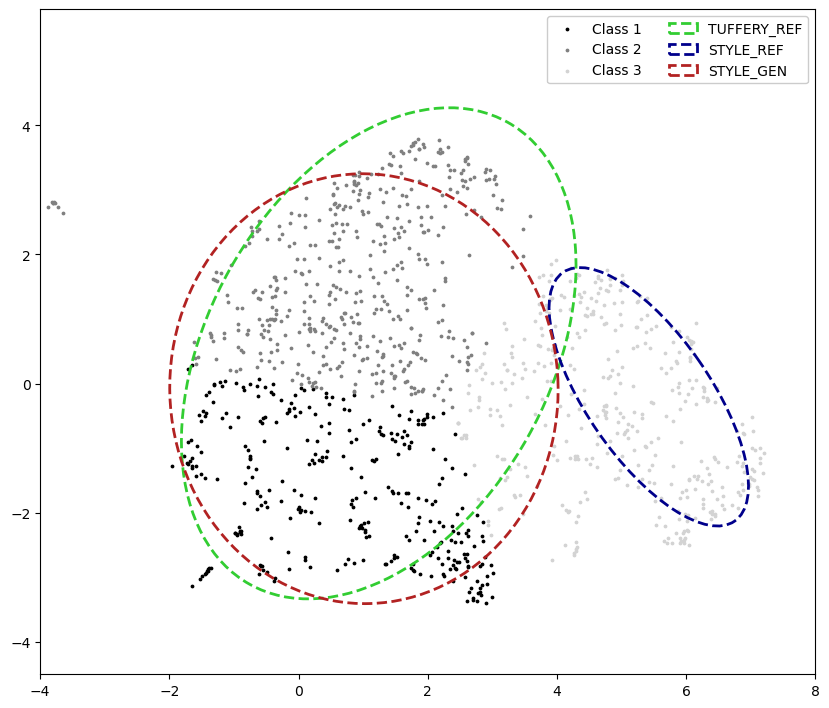

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

transformed_tuffery_copy = - transformed_tuffery
transformed_proust_copy = - transformed_proust
transformed_celine_copy = - transformed_celine
transformed_yourcenar_copy = - transformed_yourcenar
transformed_proust_gpt_copy = - transformed_proust_gpt
transformed_proust_mistral_copy = - transformed_proust_mistral
transformed_proust_gemini_copy = - transformed_proust_gemini
transformed_celine_gpt_copy = - transformed_celine_gpt
transformed_celine_mistral_copy = - transformed_celine_mistral
transformed_celine_gemini_copy = - transformed_celine_gemini
transformed_yourcenar_gpt_copy = - transformed_yourcenar_gpt
transformed_yourcenar_mistral_copy = - transformed_yourcenar_mistral
transformed_yourcenar_gemini_copy = - transformed_yourcenar_gemini

class_tuffery = transformed_tuffery_copy
class_B1 = np.concatenate((transformed_proust_copy, transformed_celine_copy, transformed_yourcenar_copy))
class_proust_gen = np.concatenate((transformed_proust_gpt_copy, transformed_proust_mistral_copy, transformed_proust_gemini_copy))
class_celine_gen = np.concatenate((transformed_celine_gpt_copy, transformed_celine_mistral_copy, transformed_celine_gemini_copy))    
class_yourcenar_gen = np.concatenate((transformed_yourcenar_gpt_copy, transformed_yourcenar_mistral_copy, transformed_yourcenar_gemini_copy))    
class_A2 = np.concatenate((class_proust_gen, class_celine_gen, class_yourcenar_gen))

data = np.concatenate((class_tuffery, class_B1, class_A2))
labels = np.concatenate(([0]*len(class_tuffery), 
                         [1]*len(class_B1),
                         [2]*len(class_A2),
                         ))
results = np.array(apply_kmeans(data, n_clusters=3)[0])

# Create masks and filtered arrays
data_0 = data[results == 3]
data_1 = data[results == 1]
data_2 = data[results == 2]

ax.scatter(data_0[:,0], data_0[:,1], c="black", s=3, label="Class 1")
ax.scatter(data_1[:,0], data_1[:,1], c="grey", s=3, label="Class 2")
ax.scatter(data_2[:,0], data_2[:,1], c="lightgrey", s=3, label="Class 3")

# Draw ellipses
plot_confidence_ellipse(transformed_tuffery_copy, ax, n_std=n_std, edgecolor='limegreen', label='TUFFERY_REF')

plot_confidence_ellipse(np.concatenate((transformed_proust_copy,transformed_yourcenar_copy, transformed_celine_copy)), ax, n_std=n_std, edgecolor='darkblue', label='STYLE_REF')

plot_confidence_ellipse(np.concatenate((transformed_proust_gpt_copy, transformed_proust_mistral_copy, transformed_proust_gemini_copy, 
                                        transformed_yourcenar_gpt_copy, transformed_yourcenar_mistral_copy, transformed_yourcenar_gemini_copy, 
                                        transformed_celine_mistral_copy, transformed_celine_gpt_copy, transformed_celine_gemini_copy)), 
                        ax, n_std=n_std, edgecolor='firebrick', label='STYLE_GEN')

ax.set_aspect('equal')
ax.set_ylim(-4.5, 5.8)
ax.set_xlim(-4, 8)
ax.legend(loc='upper right',
          ncol=2, 
          framealpha=1)

plt.show()

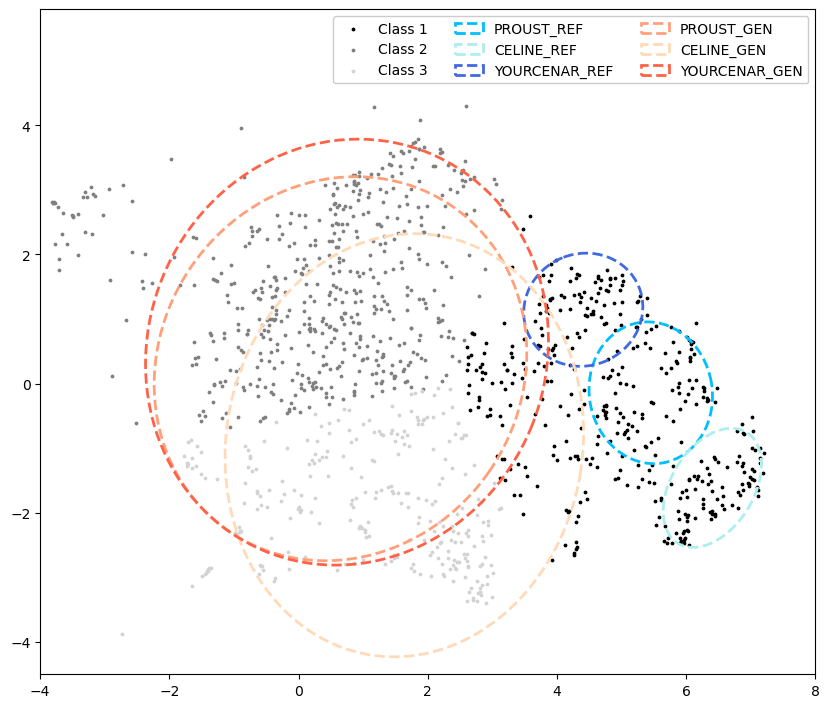

In [45]:
n_std = np.sqrt(chi2.ppf(0.7, df=2)) 

fig, ax = plt.subplots(figsize=(10, 10))

class_tuffery = transformed_tuffery
class_tuffery[:, [0, 1]] = class_tuffery[:, [1, 0]]
class_tuffery[:, 1] = - class_tuffery[:, 1] 

transformed_proust_copy = - transformed_proust
transformed_celine_copy = - transformed_celine
transformed_yourcenar_copy = - transformed_yourcenar
class_B1 = np.concatenate((transformed_proust_copy, transformed_celine_copy, transformed_yourcenar_copy))


transformed_proust_gpt_copy = - transformed_proust_gpt
transformed_proust_mistral_copy = - transformed_proust_mistral
transformed_proust_gemini_copy = - transformed_proust_gemini
class_proust_gen = np.concatenate((transformed_proust_gpt_copy, transformed_proust_mistral_copy, transformed_proust_gemini_copy))

transformed_celine_gpt_copy = - transformed_celine_gpt
transformed_celine_mistral_copy = - transformed_celine_mistral
transformed_celine_gemini_copy = - transformed_celine_gemini
class_celine_gen = np.concatenate((transformed_celine_gpt_copy, transformed_celine_mistral_copy, transformed_celine_gemini_copy))    

transformed_yourcenar_gpt_copy = - transformed_yourcenar_gpt
transformed_yourcenar_mistral_copy = - transformed_yourcenar_mistral
transformed_yourcenar_gemini_copy = - transformed_yourcenar_gemini
class_yourcenar_gen = np.concatenate((transformed_yourcenar_gpt_copy, transformed_yourcenar_mistral_copy, transformed_yourcenar_gemini_copy)) 

class_A2 = np.concatenate((class_proust_gen, class_celine_gen, class_yourcenar_gen))

data = np.concatenate((class_tuffery, class_B1, class_A2))
labels = np.concatenate(([0]*len(class_tuffery), 
                         [1]*len(class_B1),
                         [2]*len(class_A2),
                         ))
results = np.array(apply_kmeans(data, n_clusters=3)[0])

# Create masks and filtered arrays
data_0 = data[results == 3]
data_1 = data[results == 1]
data_2 = data[results == 2]

lines = []

lines.append(ax.scatter(data_0[:,0], data_0[:,1], c="black", s=3, label="Class 1"))
lines.append(ax.scatter(data_1[:,0], data_1[:,1], c="grey", s=3, label="Class 2"))
lines.append(ax.scatter(data_2[:,0], data_2[:,1], c="lightgrey", s=3, label="Class 3"))

# # Draw ellipses"paleturquoise", "deepskyblue", "royalblue"
# # lines.append(plot_confidence_ellipse(transformed_tuffery, ax, n_std=n_std, edgecolor='darkblue', label='TUFFERY_REF'))
lines.append(plot_confidence_ellipse(transformed_proust_copy, ax, n_std=n_std, edgecolor='deepskyblue', label ='PROUST_REF'))
lines.append(plot_confidence_ellipse(transformed_celine_copy, ax, n_std=n_std, edgecolor='paleturquoise', label ='CELINE_REF'))
lines.append(plot_confidence_ellipse(transformed_yourcenar_copy, ax, n_std=n_std, edgecolor='royalblue', label ='YOURCENAR_REF'))

lines.append(plot_confidence_ellipse(np.concatenate((transformed_proust_gpt_copy, transformed_proust_mistral_copy, transformed_proust_gemini_copy)), ax, n_std=n_std, edgecolor='lightsalmon', label ='PROUST_GEN'))
lines.append(plot_confidence_ellipse(np.concatenate((transformed_celine_mistral_copy, transformed_celine_gpt_copy, transformed_celine_gemini_copy)), ax, n_std=n_std, edgecolor='peachpuff', label ='CELINE_GEN'))
lines.append(plot_confidence_ellipse(np.concatenate((transformed_yourcenar_gpt_copy, transformed_yourcenar_mistral_copy, transformed_yourcenar_gemini_copy)), ax, n_std=n_std, edgecolor='tomato', label ='YOURCENAR_GEN'))

ax.set_aspect('equal')
ax.set_ylim(-4.5, 5.8)
ax.set_xlim(-4, 8)
ax.legend(
          loc='upper right', 
          ncol=3, 
          framealpha=1)
plt.show()